In [1]:
reset -fs

<img src="./figures/neonbrand-AOJGuIJkoBc-unsplash.jpg" width="800" height="300" />
Photo by NeONBRAND on Unsplash

# Background and feature understanding

## About Peer-to-Peer-Lending

## About Lending Club

LendingClub is a US peer-to-peer lending company and the world's largest peer-to-peer lending platform.

***Lending Club enables borrowers to create unsecured personal loans between 1,000 USD and 40,000 USD. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.***
[Wikipedia - Lending club](https://en.wikipedia.org/wiki/LendingClub)

For this project we chose a dataset from Lending Club approved personal loans between 2007 and 2011. The data can be found on www.lendingclub.com. The purpose of the analysis is to reduce defaults, improve profitability and help the company and investors determine interest rates. We will use machine learning models to analyze credit risk as a binary classification problem.

## About the data

### Description of the features in the data

The Dataset of Lending Club, which is used for this projekt, contains data about loans from 2007 to 2011.
There is a lot of information about the Members (=Borrowers). These informations could be divided in some Subcategories:

* Personal Information: Income, Location, Obligations, etc. This category contains information statet by the member itself in the registration process or is publicly available

* Payment Behavior: Insights on the payment behavior of the members regarding their Lending Club loans. This Category contains information which is **not** known for new members.

For further details please see EDA-Chapter or the following spreadsheet with explanations:

[Lending Club - Feature Explanation](./data/feature_info_as_table.ods)

# Setting up the Notebook

## import of relevant modules

In [1]:
import os

import math
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, accuracy_score

sns.set()

## Macros

In [2]:
DATA_FOLDER = './data/'
FIG_FOLDER = './figures/'

## Utile Functions

### Plotting functions

In [3]:
# make general plots to examine each feature
def plot_var(df,col_name, full_name, continuous):
    """
    Visualize a variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,3))
    # plot1: counts distribution of the variable
    
    if continuous:  
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

          
    # plot2: bar plot of the variable grouped by loan_status
    if continuous:
        sns.boxplot(x=col_name, y='target', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        Charged_Off_rates = df.groupby(col_name)['target'].value_counts(normalize=True)[:,0]
        sns.barplot(x=Charged_Off_rates.index, y=Charged_Off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged Off')
        ax2.set_title('Charged Off Rate by ' + full_name)
        ax2.set_xlabel(full_name)
    
    # plot3: kde plot of the variable gropued by loan_status
    if continuous:  
        facet = sns.FacetGrid(df, hue = 'target', size=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        #facet.set(xlim=(df[col_name].min(), df[col_name].max()))
        facet.add_legend()  
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue='target', data=df, order=sorted(df[col_name].unique()) )
     
    plt.tight_layout()

### Save figure

In [4]:
def save_fig(sec_name, fig_name, tight_layout=True):
    path = os.path.join(FIG_FOLDER , sec_name + '_'  + fig_name + ".png")
    print("Saving figure", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=600)

### Sklean Pipeline Pandas support

In [147]:
from sklearn.base import BaseEstimator, TransformerMixin

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

# Cleaning

## Inital Data import

In [111]:
df = pd.read_csv(DATA_FOLDER + 'loans_2007.csv')
OrgRowCount = df.shape[0]
OrgColCount = df.shape[1]

/Users/torben/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## dealing with NAN and numbers in strings 

In [112]:
# drop dublicated last rows seem to be sum of above and None lines
df = df.drop_duplicates()
## there seems to 3 with many empty cells so this is fine
df = df.dropna(thresh=50,axis=0)
df = df[~df.revol_util.isna()]
df = df[~df.last_credit_pull_d.isna()]

In [113]:
# transfer string 'num%' to number 0-1
df.revol_util = df.revol_util.apply(lambda x: str(x).replace('%','')).astype('float64')/100
df.int_rate = df.int_rate.apply(lambda x: str(x).replace('%','')).astype('float64')/100

In [114]:
# emp_length transfrom form string to number (<1 years ,  years, 10+ years etc)
def Trans_empValue(s):
    if type(s) is float:
        return 0.
    if re.search('\<',s):
        return 0.5
    else:
        return float(re.search('\d+',s).group())

df.emp_length = df.emp_length.apply(lambda x: Trans_empValue(x))

In [115]:
# no info about bankruptcie will be interpreted as none
df.pub_rec_bankruptcies = df.pub_rec_bankruptcies.fillna(0.0).astype('uint8')
# cap the very view that have amount of 2 ( could be spouses etc...)
df.pub_rec_bankruptcies = df.pub_rec_bankruptcies.apply(lambda x: 1 if x > 0 else 0)
df.pub_rec_bankruptcies.value_counts()

0    40476
1     1853
Name: pub_rec_bankruptcies, dtype: int64

In [116]:
# small feature engineering for EDA - actually misplaced in the chapter but was easy to do
display(df[df.last_pymnt_d.isna()].loan_status.value_counts())
df['has_made_pymnt'] = df.last_pymnt_d.apply(lambda x: 1 if x else 0)
df = df.drop(['last_pymnt_d'],axis=1)

Charged Off                                            62
Does not meet the credit policy. Status:Charged Off    12
Name: loan_status, dtype: int64

## Droping columns with no information

In [117]:
# title could be filtered by keyword debt etc.. but categoriy of purpose does better job thereby drop it
df = df.drop(['title'], axis=1)

In [118]:
# collections_12_mths_ex_med and chargeoff_within_12_mths drop the column all are the same = 0.0
df = df.drop(['chargeoff_within_12_mths', 'collections_12_mths_ex_med'], axis=1)
# application_type - only indvitual in the data can be droped
df = df.drop(['application_type'],axis=1)
# no info 
df = df.drop(['initial_list_status'],axis=1)
# no info in the data 
df = df.drop(['acc_now_delinq'],axis=1)
# not much info only 2 
df = df.drop(['delinq_amnt'],axis=1)
# only one value diffrent
df = df.drop(['tax_liens'],axis=1)
# all have no only one is yes
df = df.drop(['pymnt_plan'],axis=1)
# all are 1
df = df.drop(['policy_code'],axis=1)

## recheck on the NAN 

In [119]:
df.isnull().sum()

id                            0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                  2590
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
out_prncp                     0
out_prncp_inv                 0
total_py

--- > leavs only the emp_title -> push to feature engineering

## Dublication check on ids

In [120]:
print(df.id.duplicated().value_counts())
print(df.member_id.duplicated().value_counts())

False    42329
Name: id, dtype: int64
False    42329
Name: member_id, dtype: int64


--- > no doubles therfor the id has no value for prediction and nothing needs to be cleaned

In [121]:
df = df.drop(['id','member_id'],axis=1)

## Objects in the data check shellow if categorys

In [122]:
df.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42329 entries, 0 to 42474
Data columns (total 13 columns):
term                   42329 non-null object
grade                  42329 non-null object
sub_grade              42329 non-null object
emp_title              39739 non-null object
home_ownership         42329 non-null object
verification_status    42329 non-null object
issue_d                42329 non-null object
loan_status            42329 non-null object
purpose                42329 non-null object
zip_code               42329 non-null object
addr_state             42329 non-null object
earliest_cr_line       42329 non-null object
last_credit_pull_d     42329 non-null object
dtypes: object(13)
memory usage: 4.5+ MB


In [123]:
## Term seems to be 36 month or 60 month ... keep category but make shorter and kill spaces
df.term = df.term.apply(lambda x: str(x).replace(' ', '').replace('months','m'))

In [124]:
#combine NONE and OTHER since there are only 2
# print(df.home_ownership.value_counts())
df.home_ownership = df.home_ownership.apply(lambda x: 'OTHER' if x=='NONE' else x)


_d columns have date info - > push to feature engineering dealing with datetime 

## cleaning date type

In [54]:
def time_converter(elem):
    month_to_num = {'Jan':'01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06',
                    'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}
    temp_elem = elem.split('-')
    val = '-'.join([month_to_num[temp_elem[0]],temp_elem[1]])
    date = pd.to_datetime(val)
    return date

In [128]:
# defining the columns which needs to be confirmed
date_column = ['last_credit_pull_d','earliest_cr_line','issue_d']
for i in date_column:
    df[i] = df[i].apply(lambda x: time_converter(x))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42329 entries, 0 to 42474
Data columns (total 40 columns):
loan_amnt                  42329 non-null float64
funded_amnt                42329 non-null float64
funded_amnt_inv            42329 non-null float64
term                       42329 non-null object
int_rate                   42329 non-null float64
installment                42329 non-null float64
grade                      42329 non-null object
sub_grade                  42329 non-null object
emp_title                  39739 non-null object
emp_length                 42329 non-null float64
home_ownership             42329 non-null object
annual_inc                 42329 non-null float64
verification_status        42329 non-null object
issue_d                    42329 non-null datetime64[ns]
loan_status                42329 non-null object
purpose                    42329 non-null object
zip_code                   42329 non-null object
addr_state                 42329 non-null o

## Export Cleaned Data 

In [129]:
df.to_pickle(DATA_FOLDER + 'clean_pass_01p2.pkl')
print(f'{(1-df.shape[0]/OrgRowCount)*100}% data loss of cleaning')

0.4913254031689296% data loss of cleaning


# Target design / engineering

From Task description:

The purpose of the analysis is to reduce defaults, improve profitability and help the company and investors determine interest rates. 

This means we have to find something like default or Charge-Off for negativ and Fully Paid as positive

the column loan_status hosts such information


## Section Data import

In [130]:
df = pd.read_pickle(DATA_FOLDER + 'clean_pass_01p2.pkl')
OrgRowCount = df.shape[0]
OrgColCount = df.shape[1]

## Encode the Loan Status to binary

In [131]:
df.loan_status.value_counts()

Fully Paid                                             33052
Charged Off                                             5606
Does not meet the credit policy. Status:Fully Paid      1917
Current                                                  961
Does not meet the credit policy. Status:Charged Off      738
Late (31-120 days)                                        24
In Grace Period                                           20
Late (16-30 days)                                          8
Default                                                    3
Name: loan_status, dtype: int64

Encode mapping:
* Fully Paid - positive
* Does not meet the credit policy. Status:Fully Paid - postive based on comparison on annual income

* Current - (half positive not evaluated therefore drop)

* Charged off - negative
* Does not meet the credit policy. Status:Charged Off - negative

* Late (31-120 days) - negative 

* Late (16-30 days) - (half positive not evaluated therefore drop)
* In Grace Period - (half positive not evaluated therefore drop)

* Default - negative

In [132]:
def DefTargetFrom_loan_Status(s):
    if s=='Fully Paid':
        return 1
    elif s=='Does not meet the credit policy. Status:Fully Paid':
        return 1
    elif s=='Charged Off':
        return 0
    elif s=='Does not meet the credit policy. Status:Charged Off':
        return 0
    elif s=='Late (31-120 days)':
        return 0
    elif s=='Default':
        return 0
    else:
        return None # all others define as None to drop them from data 

# read status to new column - target    
df['target'] = df.loan_status.apply(lambda x: DefTargetFrom_loan_Status(x))

# kill the view not 
df.isna().sum()
df = df.dropna()
#df.shape

## Export Cleaned Data 

In [133]:
df.to_pickle(DATA_FOLDER + 'clean_pass_01p2_Ptarget.pkl')
print(f'{(1-df.shape[0]/OrgRowCount)*100}% data loss of cleaning')

8.294549835809962% data loss of cleaning


# Feature Engineering

## Employment_title_ident

### Section Data Import

In [134]:
df = pd.read_pickle(DATA_FOLDER + 'clean_pass_01p2_Ptarget.pkl')

# https://www.kaggle.com/ash316/forbes-top-2000-companies
df_company = pd.read_csv(DATA_FOLDER + 'forbes2013.csv') # company names to get label for known companys

### match known companys

In [135]:
df['emp_ident'] = df['emp_title']

In [136]:
KNOWN_COMPANY_MARKER = 'known_company'

def title_id_known_company(emp_title_entry):
    try:
        founds = df_company.Company.str.contains(emp_title_entry).value_counts()
    except:
        return emp_title_entry
    
    if len(founds)>1:
         return KNOWN_COMPANY_MARKER
    else:
        return emp_title_entry

In [137]:
df['emp_ident'] = df['emp_ident'].apply(lambda emp_title: title_id_known_company(emp_title))
#df['emp_ident'].value_counts()

/Users/torben/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """


### match groups like army, public, self employment ...

In [138]:
def title_to_ident(emp_title_entry):
    if emp_title_entry == KNOWN_COMPANY_MARKER:
        return emp_title_entry
    elif (re.search('Army|Military',emp_title_entry ,re.I) is None) == False :
        return 'army'
    elif (re.search('self',emp_title_entry ,re.I) is None) == False :
        return 'self_emp'
    elif (re.search('city|state|public|district|school|schools|Government|Sheriff|county|civil|police|National Guard',emp_title_entry ,re.I) is None) == False :
        return 'puplic'
    elif (re.search('bank',emp_title_entry ,re.I) is None) == False :
        return 'bank'
    else:
        return 'unknown' 

In [139]:
df['emp_ident'] = df['emp_ident'].apply(lambda emp_title: title_to_ident(emp_title))
df['emp_ident'].value_counts()

unknown          31255
puplic            3696
known_company     2464
bank               696
army               476
self_emp           231
Name: emp_ident, dtype: int64

### Export data with feature added

In [140]:
df.to_pickle(DATA_FOLDER + 'clean_pass_01p2_Ptarget_FPemp_ident.pkl')

## feature importance test

### Section data import

In [141]:
df = pd.read_pickle(DATA_FOLDER + 'clean_pass_01p2_Ptarget_FPemp_ident.pkl')

### pick the possible features 

In [142]:
x_col = ['addr_state',
'annual_inc',
'dti',
'emp_length',
'home_ownership',
'loan_amnt',
'open_acc',
'pub_rec',
'pub_rec_bankruptcies',
'purpose',
'term',
'verification_status',
 'emp_ident']

y_col = ['target']

df_x = df[x_col]
df_y = df[y_col]

### Encoding the dummys with pandas

In [143]:
df_x_encoded = pd.get_dummies(df_x, drop_first=True)
#for i in df_x_encoded.columns:
#    print(i)
df_x_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38818 entries, 1 to 42474
Data columns (total 80 columns):
annual_inc                             38818 non-null float64
dti                                    38818 non-null float64
emp_length                             38818 non-null float64
loan_amnt                              38818 non-null float64
open_acc                               38818 non-null float64
pub_rec                                38818 non-null float64
pub_rec_bankruptcies                   38818 non-null int64
addr_state_AL                          38818 non-null uint8
addr_state_AR                          38818 non-null uint8
addr_state_AZ                          38818 non-null uint8
addr_state_CA                          38818 non-null uint8
addr_state_CO                          38818 non-null uint8
addr_state_CT                          38818 non-null uint8
addr_state_DC                          38818 non-null uint8
addr_state_DE                          

### create preprocessing pipeline

In [148]:
preprocess_pipeline = make_pipeline(
    ColumnSelector(columns=df_x_encoded.columns),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector('float64'),
            StandardScaler()
        )),
        ("bool_features", make_pipeline(
            TypeSelector('int64'),
        )),
        ("dummy_features", make_pipeline(
            TypeSelector('uint8'),
        )),
        #("categorical_features", make_pipeline(
        #    TypeSelector("category"),
        #    OneHotEncoder()
        #)),
    ]))

In [149]:
# checks on the preprocessing pipeline
preprocess_pipeline.fit(df_x_encoded)
X_transformed = preprocess_pipeline.transform(df_x_encoded)    
print(X_transformed.shape)
print(df_x_encoded.shape)
df_y.shape
#df.info()

(38818, 80)
(38818, 80)


(38818, 1)

### calculate decision tree importance

In [150]:
clf = DecisionTreeClassifier()
#clf = RandomForestClassifier(n_estimators=6,max_leaf_nodes=2)
clf.fit(X_transformed, df_y)
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=df_x_encoded.columns, columns=["Importance"])
importance = importance.sort_values(['Importance'], ascending=True)
print(precision_score(df_y.values, clf.predict(X_transformed)))
accuracy_score(df_y, clf.predict(X_transformed))

1.0


1.0

Saving figure dectree_feat_importance


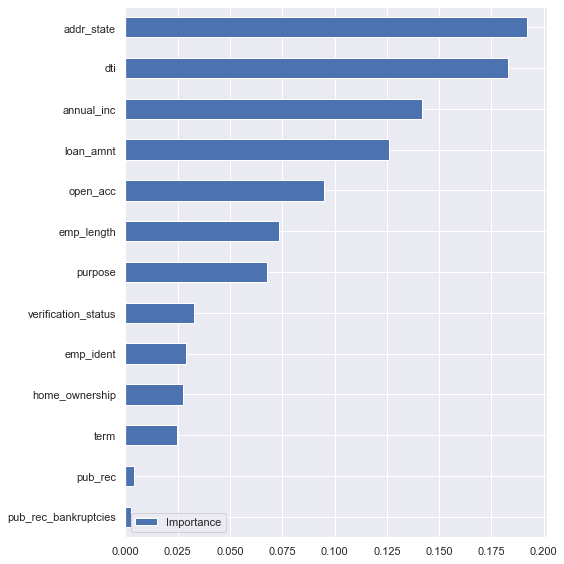

In [151]:
# create plot with joined importance of dummies
importance_join = pd.DataFrame(index = df_x.columns)
for i1 in df_x.select_dtypes('object').columns:
    #print(i1)
    t_sum = 0
    for i2 in importance.index:
        if i1 in i2:
            #print ('--' + i2)
            t_sum += importance.loc[i2,'Importance']
    
    importance_join.loc[i1,'Importance'] = t_sum
            
for i in df_x.select_dtypes(np.number).columns:
    importance_join.loc[i,'Importance'] = importance.loc[i,'Importance']
    
importance_join = importance_join.sort_values(['Importance'], ascending=True)
importance_join.plot(kind='barh', figsize=(8,8))

save_fig('feat_eng', 'dectree_feat_importance', tight_layout=True)

## Feature Correlation

### Section data import

In [152]:
df = pd.read_pickle(DATA_FOLDER + 'clean_pass_01p2_Ptarget_FPemp_ident.pkl')

### correlation head map

In [153]:
x_col = ['addr_state',
'annual_inc',
'dti',
'emp_length',
'home_ownership',
'loan_amnt',
'open_acc',
'pub_rec',
'pub_rec_bankruptcies',
'purpose',
'term',
'verification_status',
 'emp_ident']

y_col = ['target']

In [154]:
# calculate the correlation matrix
df_xy_encoded = pd.get_dummies(df[y_col + x_col], drop_first=True)
corr = df_xy_encoded.corr()

corr = corr.target
importance.name = 'correlation'

In [155]:
corr_join = pd.Series(index = df[y_col + x_col].columns)
for i1 in df[y_col + x_col].select_dtypes('object').columns:
    #print(i1)
    t_sum = 0
    for i2 in corr.index:
        if i1 in i2:
            #print ('--' + i2)
            t_sum += corr[i2]
    
    corr_join.loc[i1] = t_sum
            
for i in df[y_col + x_col].select_dtypes(np.number).columns:
    corr_join[i] = corr[i]
    
corr_join.apply(lambda x: abs(x)).sort_values(ascending = False).drop('target')

term                    0.156560
loan_amnt               0.055218
pub_rec                 0.053128
pub_rec_bankruptcies    0.050241
dti                     0.045651
purpose                 0.041740
annual_inc              0.035885
verification_status     0.033529
home_ownership          0.031948
addr_state              0.019093
emp_length              0.018520
open_acc                0.002009
emp_ident               0.000184
dtype: float64

Saving figure feat_target_corr


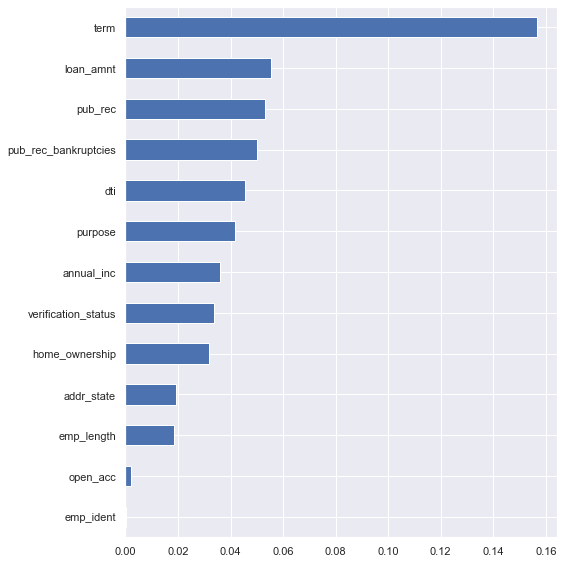

In [156]:
corr_join.apply(lambda x: abs(x)).sort_values(ascending = True).drop('target').plot(kind='barh', figsize=(8,8))
save_fig('feat_eng', 'feat_target_corr', tight_layout=True)

## Combine correlation and feature importance (you need both in memory)

In [157]:
imcor = importance_join.join(pd.DataFrame(corr_join.apply(lambda x: abs(x)), columns=['correlation']))
imcor['c'] = MinMaxScaler().fit_transform(imcor.correlation.values.reshape(-1, 1))
imcor['i'] = MinMaxScaler().fit_transform(imcor.Importance.values.reshape(-1, 1))
imcor = imcor.eval('sum = (c + i)/2')
imcor.sort_values(by=['sum'], ascending = False)

,Importance,correlation,c,i,sum
dti,0.182973,0.045651,0.290753,0.952602,0.621678
addr_state,0.191947,0.019093,0.120923,1.000000,0.560461
term,0.024511,0.156560,1.000000,0.115633,0.557816
loan_amnt,0.126198,0.055218,0.351934,0.652724,0.502329
annual_inc,0.142029,0.035885,0.228302,0.736344,0.482323
purpose,0.067653,0.041740,0.265748,0.343503,0.304625
open_acc,0.094886,0.002009,0.011673,0.487339,0.249506
emp_length,0.073614,0.018520,0.117261,0.374987,0.246124
verification_status,0.032832,0.033529,0.213237,0.159582,0.186409
pub_rec,0.004077,0.053128,0.338572,0.007702,0.173137


--- > this can be used to choose the features

# EDA

## Initial Data import

In [18]:
# import the cleaned data
df_eda = pd.read_pickle(DATA_FOLDER + 'clean_pass_01p2_Ptarget_FPemp_ident.pkl')
pd.options.display.max_columns = None

## Overview

In [6]:
# How many data to we have
print('We see {} rows and {} cols in the data'.format(df_eda.shape[0],df_eda.shape[1]))

We see 38818 rows and 42 cols in the data


In [167]:
# Let's have a short look at the head of the data
df_eda.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies,has_made_pymnt,target,emp_ident
1,2500.0,2500.0,2500.0,60m,0.1527,59.83,C,C4,Ryder,0.5,RENT,30000.0,Source Verified,2011-12-01,Charged Off,car,309xx,GA,1.0,0.0,1999-04-01,5.0,3.0,0.0,1687.0,0.094,4.0,0.0,0.0,1008.71,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,2013-09-01,0,1,0.0,unknown
3,10000.0,10000.0,10000.0,36m,0.1349,339.31,C,C1,AIR RESOURCES BOARD,10.0,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,other,917xx,CA,20.0,0.0,1996-02-01,1.0,10.0,0.0,5598.0,0.210,37.0,0.0,0.0,12231.89,12231.89,10000.00,2214.92,16.97,0.00,0.00,357.48,2016-04-01,0,1,1.0,unknown
5,5000.0,5000.0,5000.0,36m,0.0790,156.46,A,A4,Veolia Transportaton,3.0,RENT,36000.0,Source Verified,2011-12-01,Fully Paid,wedding,852xx,AZ,11.2,0.0,2004-11-01,3.0,9.0,0.0,7963.0,0.283,12.0,0.0,0.0,5632.21,5632.21,5000.00,632.21,0.00,0.00,0.00,161.03,2016-01-01,0,1,1.0,unknown


In [168]:
# Let's have a short look at the end of the data
df_eda.tail(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies,has_made_pymnt,target,emp_ident
42454,5700.0,5700.0,1450.0,36m,0.1343,193.26,E,E1,"PEER Center, Inc.",5.0,RENT,65000.0,Not Verified,2007-08-01,Does not meet the credit policy. Status:Fully ...,debt_consolidation,333xx,FL,18.22,0.0,2004-11-01,3.0,15.0,1.0,3023.0,0.126,17.0,0.0,0.0,6957.002153,1769.76,5700.0,1257.00,0.0,0.0,0.0,198.59,2016-06-01,1,1,1.0,unknown
42466,6000.0,6000.0,1025.0,36m,0.1280,201.60,D,D4,Securitas Security Services,8.0,RENT,57000.0,Not Verified,2007-08-01,Does not meet the credit policy. Status:Fully ...,debt_consolidation,547xx,WI,15.20,2.0,1989-11-01,4.0,13.0,1.0,13622.0,0.797,31.0,0.0,0.0,7322.221721,1250.88,6000.0,1262.22,60.0,0.0,0.0,108.03,2011-05-01,1,1,1.0,unknown
42474,13000.0,13000.0,700.0,36m,0.1091,425.04,C,C3,"LendingTree, LLC",2.0,MORTGAGE,62000.0,Not Verified,2007-08-01,Does not meet the credit policy. Status:Fully ...,debt_consolidation,282xx,NC,20.00,0.0,1993-11-01,4.0,23.0,1.0,13748.0,0.502,53.0,0.0,0.0,15301.293803,823.92,13000.0,2301.29,0.0,0.0,0.0,426.53,2011-06-01,1,1,1.0,unknown


## Interest rate and default rate over time

To improve the understanding of the topic it seems to be good to have a look on to the 'normal' interest rates for loans and a rate of credit defaults outside of Lending club

In [170]:
# credit default rate US from 2007 to 2011
# source: https://www.federalreserve.gov/datadownload/Choose.aspx?rel=CHGDEL
cdr_us = pd.read_csv('./data/DRALACBN.csv').rename(columns={'DATE':'date','DRALACBN':'default_rate'})
time_df = pd.read_pickle(DATA_FOLDER + 'clean_pass_01p2_Ptarget_FPemp_ident.pkl')

In [172]:
time_df = time_df[['issue_d','target']]

In [174]:
time_df = time_df.groupby('issue_d').mean()
time_df['target'] = 1- time_df['target']
time_df = time_df.reset_index()
time_df.target=time_df.target*100

Saving figure compare_us_default_with_lc


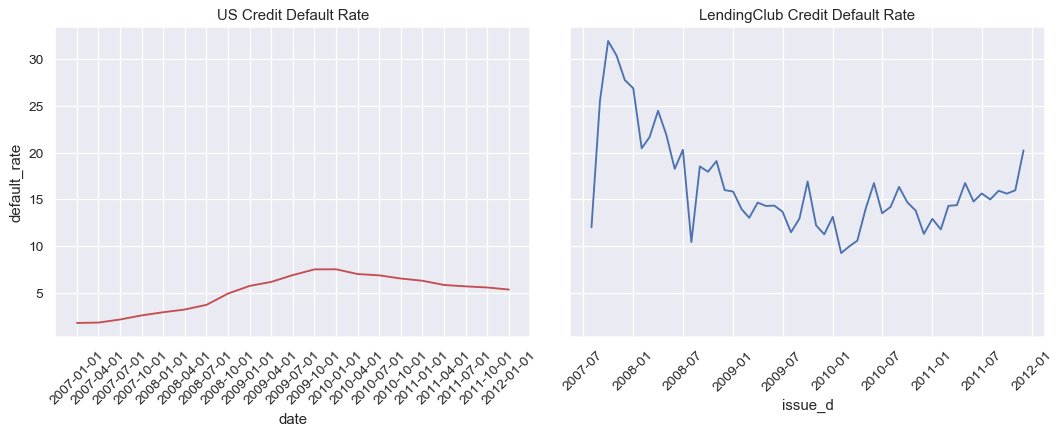

In [183]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5), dpi=90,sharey=True,)
f=sns.lineplot(x='date',y='default_rate',data=cdr_us,color='r',ax=ax1)
f=sns.lineplot(x='issue_d',y='target',data=time_df,color='b',ax=ax2)
plt.setp(ax1.get_xticklabels(), rotation=45)
ax1.set_title('US Credit Default Rate')
plt.setp(ax2.get_xticklabels(), rotation=45)
ax2.set_title('LendingClub Credit Default Rate')
save_fig('eda','compare_us_default_with_lc');

Text(0.5, 1.0, 'Lending Club Funded Amount 2007-2011')

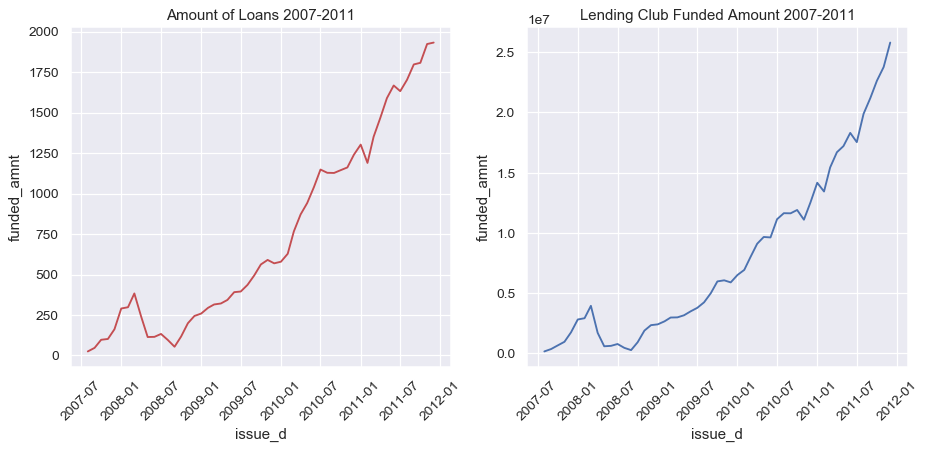

In [29]:
#df_eda.groupby('issue_d').funded_amnt.sum().reset_index()
#df_eda.groupby('issue_d').funded_amnt.count().reset_index()

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5), dpi=90)
f=sns.lineplot(x='issue_d',y='funded_amnt',data=df_eda.groupby('issue_d').funded_amnt.count().reset_index(),color='r',ax=ax1)
f=sns.lineplot(x='issue_d',y='funded_amnt',data=df_eda.groupby('issue_d').funded_amnt.sum().reset_index(),color='b',ax=ax2)
plt.setp(ax1.get_xticklabels(), rotation=45)
ax1.set_title('Amount of Loans 2007-2011')
plt.setp(ax2.get_xticklabels(), rotation=45)
ax2.set_title('Lending Club Funded Amount 2007-2011')
#save_fig('eda','compare_us_default_with_lc');

## annual_inc

In [13]:
df_eda.annual_inc.describe().round(2)

count      38818.00
mean       69161.69
std        64415.24
min         1896.00
25%        41000.00
50%        59418.00
75%        82307.25
max      6000000.00
Name: annual_inc, dtype: float64

Saving figure annual_inc_boxplot_by_target


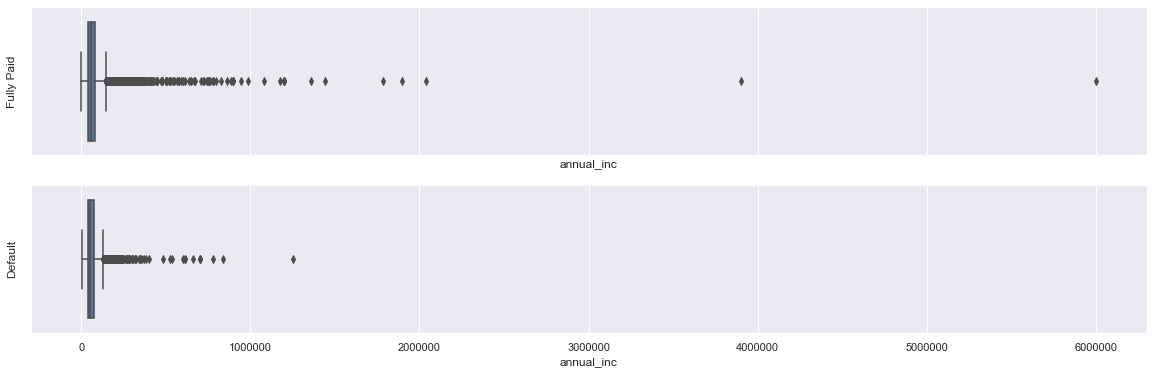

<Figure size 1440x216 with 0 Axes>

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,6))
plt.figure(figsize=(20,3))
sns.boxplot(x='annual_inc',data=df_eda.query('target==1'),ax=ax1)
sns.boxplot(x='annual_inc',data=df_eda.query('target==0'),ax=ax2)
ax1.set_ylabel('Fully Paid')
ax2.set_ylabel('Default')
save_fig('eda','annual_inc_boxplot_by_target')

The Annual income ranges from 1,896 USD to 6 Million USD with a mean annual income of around 70,000 USD
We see a lot of outliers in the boxplot, they will be handled afterwards

In [15]:
df_eda.groupby('target').annual_inc.describe().round()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,5842.0,63670.0,49235.0,3600.0,38000.0,54000.0,75000.0,1250000.0
1.0,32976.0,70135.0,66699.0,1896.0,42000.0,60000.0,84000.0,6000000.0


## Debt-to-income-ratio or short: dti

A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income (how much you earn befor interest and taxes)

For further information please see the following information of the Lending Club:
[LendingClub: DTI](https://www.lendingclub.com/loans/resource-center/calculating-debt-to-income)

In [81]:
df_eda.dti.describe()

count    38818.000000
mean        13.430969
std          6.700566
min          0.000000
25%          8.300000
50%         13.530000
75%         18.720000
max         29.990000
Name: dti, dtype: float64

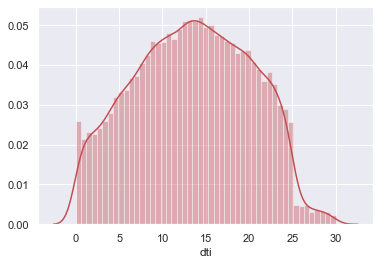

In [90]:
sns.distplot(df_eda.dti,color='r')

In [88]:
df_eda.groupby('target').dti.describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,5842.0,14.157694,6.631923,0.0,9.2400,14.46,19.40,29.96
1.0,32976.0,13.302223,6.704544,0.0,8.1375,13.37,18.59,29.99


In general the dti ranges from 0 (Absolutely no debt) to around 30% 
We see a little difference in the DTI between the 'Defaults' and the 'Fully Paid'.
Additionally this should be a percentage. Will be handled in the following cleaning section

## loan_amnt

"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."

In [16]:
df_eda.loan_amnt.describe().round(2)

count    38818.00
mean     11010.23
std       7280.11
min        500.00
25%       5300.00
50%       9600.00
75%      15000.00
max      35000.00
Name: loan_amnt, dtype: float64

The Loan Amount ranges from min. 500 USD to max. 35,000 USD with a mean of around 11,000 USD

In [17]:
df_eda.groupby('target')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,5842.0,11965.285861,7936.351894,600.0,5600.0,10000.0,16000.0,35000.0
1.0,32976.0,10841.029840,7144.408536,500.0,5200.0,9600.0,15000.0,35000.0


Saving figure loan_amount_dist


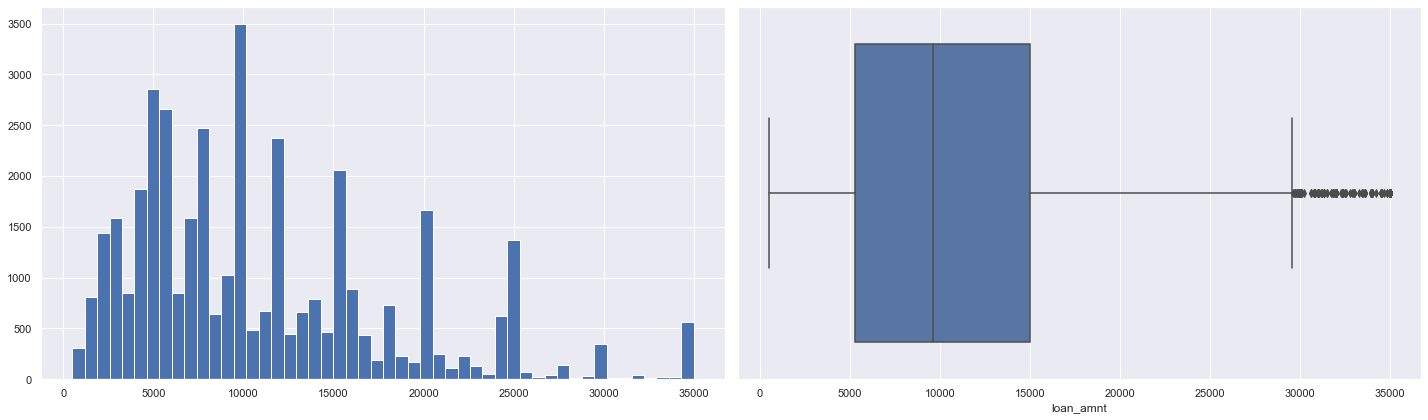

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
fig=df_eda.loan_amnt.hist(bins=50,ax=ax1)
fig=sns.boxplot(x='loan_amnt',data=df_eda,ax=ax2)
save_fig('eda', 'loan_amount_dist')

## Distribution of term

"The number of payments on the loan. Values are in months and can be either 36 or 60."

In [19]:
df_eda.term.value_counts(normalize=True)

36m    0.754701
60m    0.245299
Name: term, dtype: float64

Saving figure default_rate_by_term


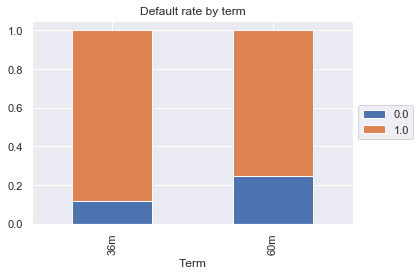

In [20]:
term = pd.crosstab(df_eda.term, df_eda.target)
term = term.div(term.sum(1).astype(float),axis=0)
term.plot(kind='bar', stacked=True, title='Default rate by term')
plt.xlabel('Term')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
save_fig('eda','default_rate_by_term')

In [21]:
df_eda.groupby('term').target.value_counts(normalize=True)

term  target
36m   1.0       0.881417
      0.0       0.118583
60m   1.0       0.751313
      0.0       0.248687
Name: target, dtype: float64

We can see, that 75% of the loans have a period of three years while the other 25% have to be paid back in 60 month or 5 years.
The default rate for the 60month period is a lot higher than for 36month (25% vs. 12%)

## Purpose

Saving figure purpose_distribution


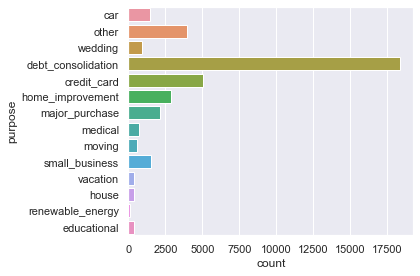

In [94]:
sns.countplot(y='purpose', data=df_eda)
save_fig('eda','purpose_distribution')

In [101]:
df_eda.groupby('purpose').target.value_counts(normalize=True).loc[:,0].sort_values()

purpose
major_purchase        0.103383
wedding               0.109589
credit_card           0.109698
car                   0.109987
home_improvement      0.129514
vacation              0.148148
debt_consolidation    0.156757
moving                0.164336
medical               0.168605
house                 0.168865
other                 0.172509
renewable_energy      0.186813
educational           0.211640
small_business        0.285164
Name: target, dtype: float64

We can see that the default rate differs a lot between the different purposes.
So this could be an interesting feature. But the distribution among the different purposes should be taken into account.
All in all this shows that the major part of the loans is used for credit card or debt consolidation but the highest default rate occurs for small business loans

## Exploring the Grading System

Saving figure grade_distribution


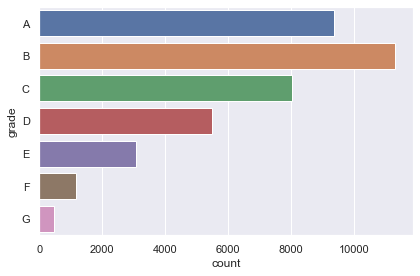

In [93]:
sns.countplot(y='grade',data=df_eda.sort_values('grade'))
save_fig('eda','grade_distribution')

Saving figure default_rate_by_grade


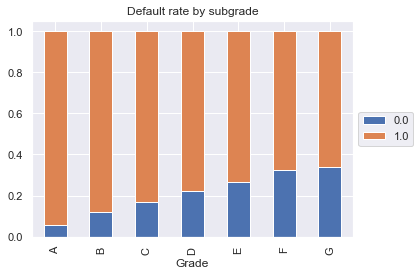

In [23]:
target = pd.crosstab(df_eda.grade, df_eda.target)
target = target.div(target.sum(1).astype(float),axis=0)
target.plot(kind='bar', stacked=True, title='Default rate by subgrade')
plt.xlabel('Grade')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
save_fig('eda','default_rate_by_grade')

Saving figure grade_count_by_target


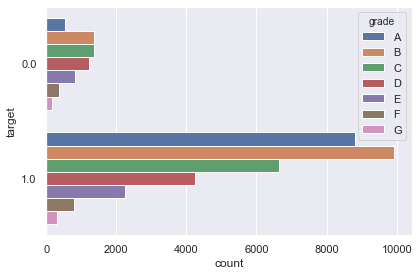

In [95]:
sns.countplot(y='target',data=df_eda.sort_values('grade'), hue='grade')
save_fig('eda','grade_count_by_target')

### Grade vs. subgrade

Saving figure int_rate_over_subgrade


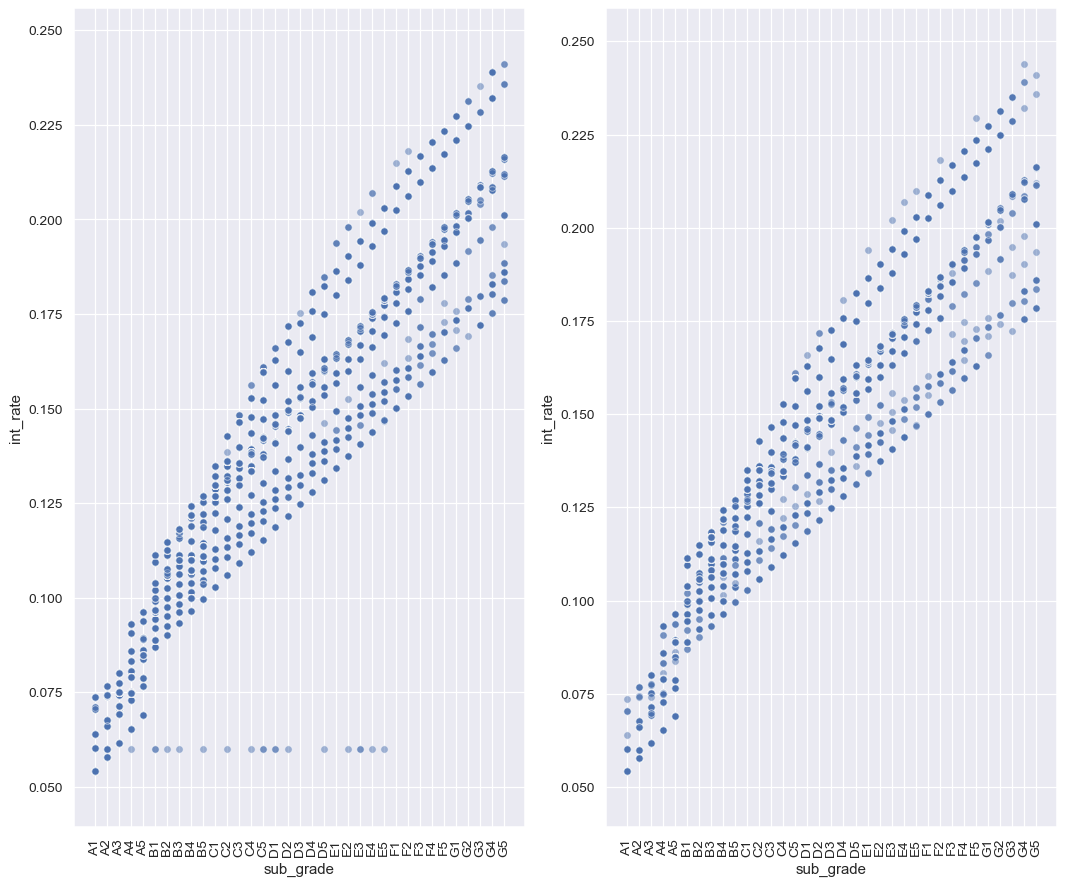

In [30]:
# predicting interest_rate 
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,10), dpi=90)
g= sns.scatterplot(x='sub_grade',y='int_rate',data=df_eda.query('target==1').sort_values('sub_grade'),alpha=.5,ax=ax1)
g= sns.scatterplot(x='sub_grade',y='int_rate',data=df_eda.query('target==0').sort_values('sub_grade'),alpha=.5,ax=ax2)
plt.setp(ax1.get_xticklabels(), rotation=90)
plt.setp(ax2.get_xticklabels(), rotation=90)
save_fig('eda','int_rate_over_subgrade');

We can see some outliers: Very low interest rates even if the grade is not that good

### Reverse Engineering Grade System (Try)

In [ ]:
# Label Encoder for Grade befor heatmap
# Trafo funktion selbst

In [ ]:
# heatmap of subgrades to determine highly correlated features
### DOES NOT WORK SO FAR: DUMMIES for Grade!
k = 10 #number of variables for heatmap
cols = df_eda.corr().nlargest(k, 'grade')['grade'].index
cm = np.corrcoef(df_eda[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
#plt.savefig('figures/price_correlation_matrix_grade')

### do the gradesystem work

In [31]:
# default rate by grade: should be higher by worse grades
loan_grade = ['target', 'grade']
pd.crosstab(df_eda[loan_grade[0]], df_eda[loan_grade[1]], normalize='columns')

grade,A,B,C,D,E,F,G
target,,,,,,,
0.0,0.057024,0.121938,0.17012,0.222019,0.26756,0.32528,0.339827
1.0,0.942976,0.878062,0.82988,0.777981,0.73244,0.67472,0.660173


As we can see from the table above and the figure in 6.7 the grading system of Lending Club seems to work generally as the default rate is gettting higher if the grade is getting worse

## Influence of location

In the dataset we see two features which are related to the location of the member:
* first 3 digits of the zipcode
* state, where the borrower is located

At this state we will drop zip code as it has a lot of different features and keep the state


In [32]:
print('Unique values in zipcode: ',df_eda.zip_code.nunique())
print('Unique values in state: ', df_eda.addr_state.nunique())

Unique values in zipcode:  831
Unique values in state:  50


Saving figure default_rate_by_state


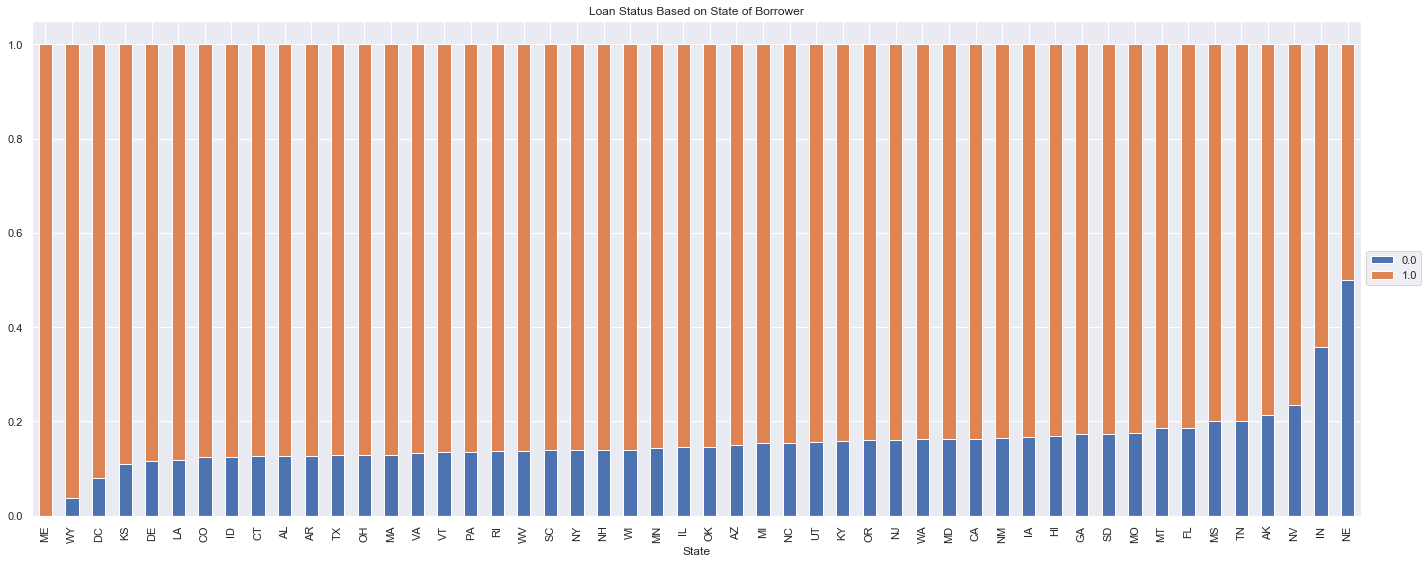

In [33]:
state = pd.crosstab(df_eda.addr_state , df_eda.target)
state = state.div(state.sum(1).astype(float), axis=0).sort_values(0)
state.plot(kind='bar', stacked=True, title='Loan Status Based on State of Borrower', figsize=(20,8))
plt.xlabel('State')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
save_fig('eda','default_rate_by_state');

Saving figure number_of_defaulted_loans_by_state


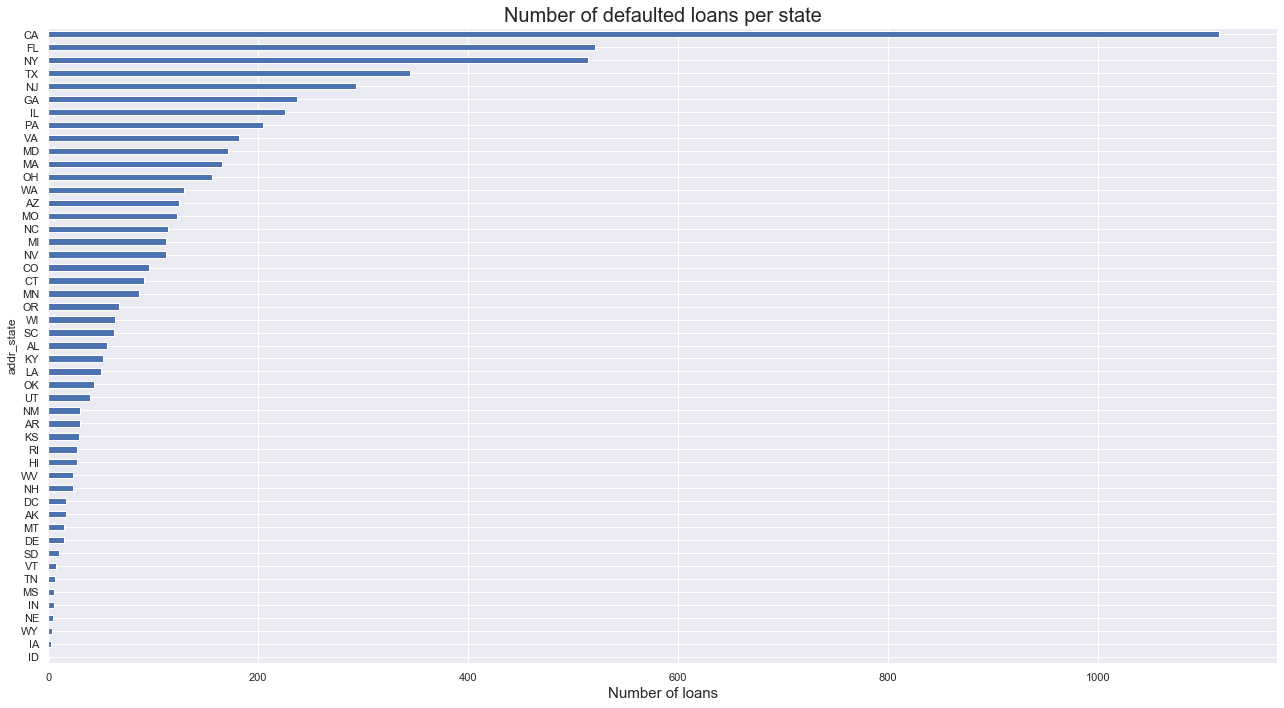

In [34]:
fig = plt.figure(figsize=(18,10))
df_eda[df_eda['target']==0].groupby('addr_state')['target'].count().sort_values().plot(kind='barh')
plt.xlabel('Number of loans',fontsize=15)
plt.title('Number of defaulted loans per state',fontsize=20)
save_fig('eda','number_of_defaulted_loans_by_state');

In [15]:
df_eda.groupby('addr_state')['target'].value_counts(normalize=True)

addr_state  target
AK          1.0       0.787500
            0.0       0.212500
AL          1.0       0.873016
            0.0       0.126984
AR          1.0       0.872881
            0.0       0.127119
AZ          1.0       0.849332
            0.0       0.150668
CA          1.0       0.836845
            0.0       0.163155
CO          1.0       0.875000
            0.0       0.125000
CT          1.0       0.873611
            0.0       0.126389
DC          1.0       0.920930
            0.0       0.079070
DE          1.0       0.884615
            0.0       0.115385
FL          1.0       0.813995
            0.0       0.186005
GA          1.0       0.827887
            0.0       0.172113
HI          1.0       0.831250
            0.0       0.168750
IA          1.0       0.833333
            0.0       0.166667
ID          1.0       0.875000
            0.0       0.125000
IL          1.0       0.853896
            0.0       0.146104
                        ...   
OK          1.0     

It can be seen that there seems to be an impact of the state where a member comes from. But as the number of loans differ a lot by state this needs to be examined in more detail to to able to be more precise on this

## verification_status vs. annual_inc

Now let's have a short look on the verification status. It says if the income statet by the member is verified by Lending club or a third source

In [35]:
df_eda.groupby('verification_status').annual_inc.describe()

,count,mean,std,min,25%,50%,75%,max
verification_status,,,,,,,,
Not Verified,17177.0,61651.798286,58297.561901,1896.0,38400.0,52800.0,73909.00,3900000.0
Source Verified,9543.0,67942.557270,83673.775690,4800.0,39996.0,55000.0,79386.00,6000000.0
Verified,12098.0,80786.056437,52439.619698,6000.0,50000.0,70000.0,97691.25,1250000.0


In [36]:
df_eda.groupby('verification_status').target.value_counts(normalize=True)

verification_status  target
Not Verified         1.0       0.862083
                     0.0       0.137917
Source Verified      1.0       0.850257
                     0.0       0.149743
Verified             1.0       0.831046
                     0.0       0.168954
Name: target, dtype: float64

In [37]:
df_eda.verification_status.value_counts(normalize=True)

Not Verified       0.442501
Verified           0.311660
Source Verified    0.245840
Name: verification_status, dtype: float64

Saving figure def_rate_by_verif


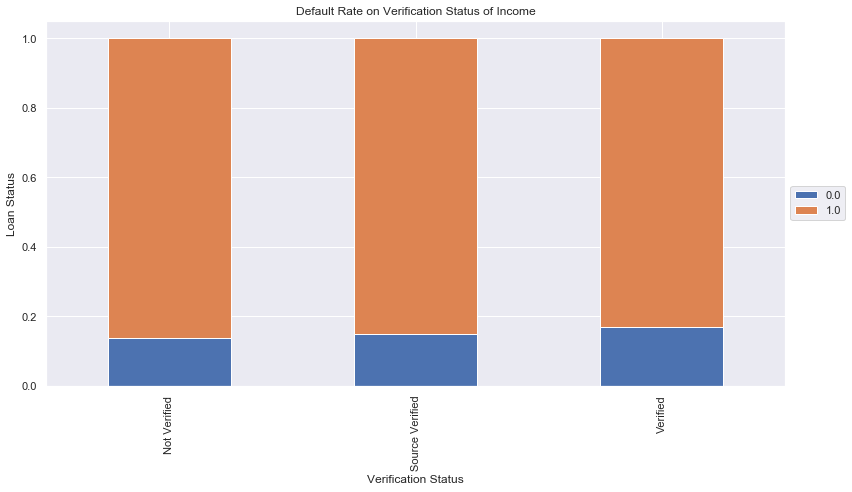

In [42]:
verif = pd.crosstab(df_eda.verification_status , df_eda.target)
verif = verif.div(verif.sum(1).astype(float), axis=0).sort_values(0)
verif.plot(kind='bar', stacked=True, title='Default Rate on Verification Status of Income', figsize=(12,7))
plt.xlabel('Verification Status')
plt.ylabel('Loan Status')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
save_fig('eda','def_rate_by_verif');

## home ownership

"The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

In [45]:
df_eda.home_ownership.value_counts(normalize=True)

RENT        0.481838
MORTGAGE    0.443737
OWN         0.071024
OTHER       0.003400
Name: home_ownership, dtype: float64

In [46]:
df_eda.groupby('home_ownership').target.value_counts(normalize=True)

home_ownership  target
MORTGAGE        1.0       0.858229
                0.0       0.141771
OTHER           1.0       0.772727
                0.0       0.227273
OWN             1.0       0.851650
                0.0       0.148350
RENT            1.0       0.841692
                0.0       0.158308
Name: target, dtype: float64

Saving figure impact_home_owner


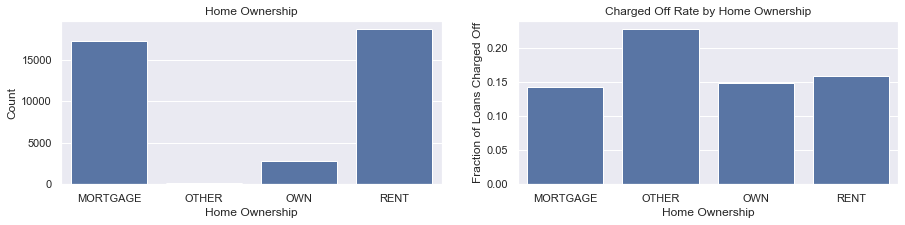

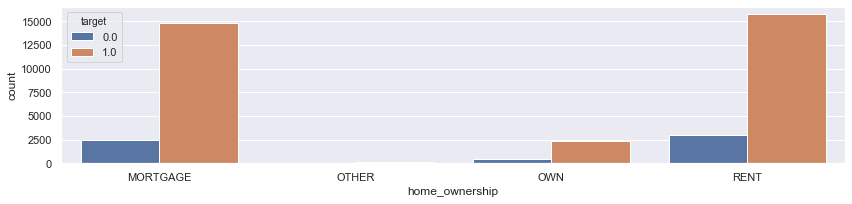

In [51]:
plot_var(df_eda, 'home_ownership', 'Home Ownership', continuous=False)
save_fig('eda','impact_home_owner')

## financial impact of default

In [ ]:
# loan_amnt vs. default rate
# funded_amnt - total_rec_prncp
# could be done

# Data Cleaning 2

Further Cleaning needed after the Exploratory Data Analysis

In [32]:
df_toclean2 = pd.read_pickle(DATA_FOLDER + 'clean_pass_01p1_PFemp_ident.pkl')

## Outlier

### Outlier Detection

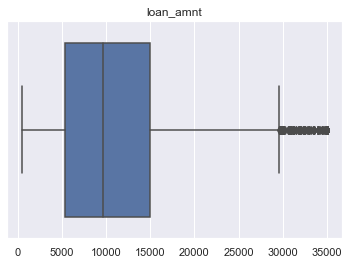

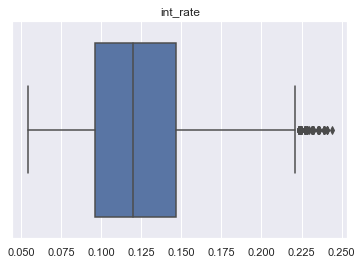

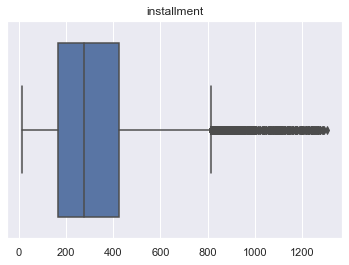

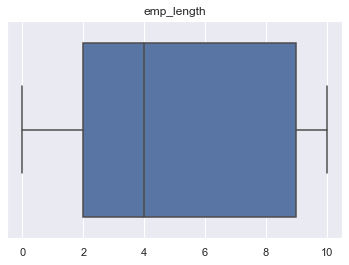

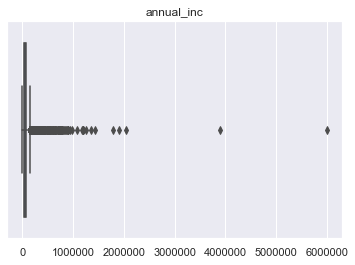

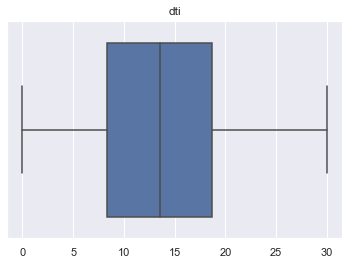

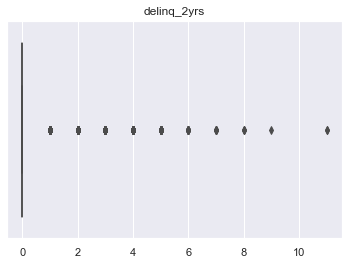

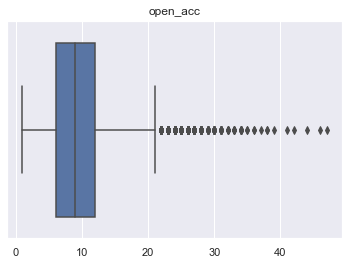

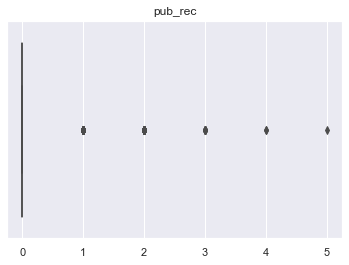

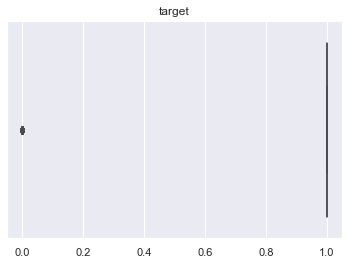

In [33]:
# for plotting purposes let's drop some columns
df_outl = df_toclean2.drop(labels=['total_pymnt', 'total_pymnt_inv', 'total_rec_prncp','total_rec_int',
                     'total_rec_late_fee', 'inq_last_6mths','revol_bal', 'revol_util',
                     'total_acc', 'out_prncp','out_prncp_inv','collection_recovery_fee',
                     'recoveries','last_pymnt_amnt','funded_amnt','funded_amnt_inv'],axis=1)

for column in df_outl.select_dtypes(include='float'):
    plt.figure()
    plt.title(column)
    sns.boxplot(x=[column],data=df_toclean2)

### Outlier Handling

#### annual_inc

As Already seen in the EDA annual_inc has heavy outliers. So let's deal with them

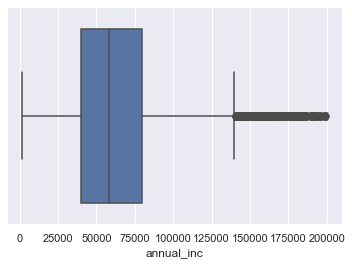

In [34]:
sns.boxplot(x='annual_inc', data=df_toclean2.query('annual_inc<200000'))

Saving figure income_wo_outl


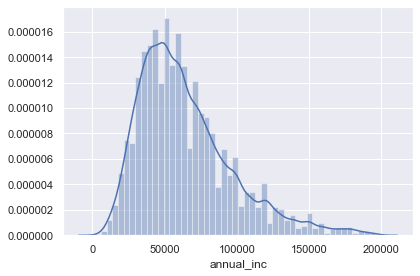

In [35]:
sns.distplot(df_toclean2.query('annual_inc<200000').annual_inc)
save_fig('clean2','income_wo_outl');

In [36]:
df_toclean2.query('annual_inc>200000').annual_inc.count()

591

In [37]:
print((df_toclean2.query('annual_inc>200000').target.count()/df_toclean2.target.count()*100).round(2),'% of the data have an income > 200.000$')
print('Which means in total:',df_toclean2.query('annual_inc>200000').target.count())

1.52 % of the data have an income > 200.000$
Which means in total: 591


Annual income over 200.000 USD will be dropped for further modelling. Loss of 1.52 % of the data

In [38]:
df_clean2 = df_toclean2.query('annual_inc<200000')

## Other stuff

### low int_rate despite that the grade is bad

In the data we can see some low interest rates (below 7.5%) which does not belong to a member of Grade A.
These Columns could lead to wrong assumptions of the model. In this case the int_rate does absolutely not fit to the grade. As there are only 18 values which all belomgs to member who have fully paid, these will be dropped.

In [39]:
df_toclean2.query('grade!="A" and int_rate < 0.075').target.value_counts()

1.0    18
Name: target, dtype: int64

In [40]:
df_clean2 = df_toclean2.drop(index=df_toclean2.query('grade!="A" and int_rate < 0.075').index)

### home_ownership

Let's have a further look onto the home_ownership. The 'Other' Category seems to be really underrepresented

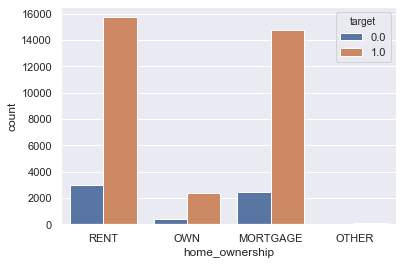

In [41]:
sns.countplot(x='home_ownership',data=df_toclean2,hue='target')

In [42]:
print(df_toclean2.groupby('home_ownership').target.count())
df_toclean2.groupby('home_ownership').target.mean()

home_ownership
MORTGAGE    17225
OTHER         132
OWN          2757
RENT        18704
Name: target, dtype: int64


home_ownership
MORTGAGE    0.858229
OTHER       0.772727
OWN         0.851650
RENT        0.841692
Name: target, dtype: float64

In [43]:
# data loss if these will be skipped
132/df_toclean2.target.count()*100

0.3400484311401927

From 0.34 % it will be difficult to predict anything so the other class will be dropped as the credit default rate ich a lot worse than in the other groups

In [44]:
df_clean2 = df_toclean2.drop(index=df_toclean2.query('home_ownership=="OTHER"').index)

In [45]:
df_clean2.query('target==0').groupby('home_ownership').target.count()

home_ownership
MORTGAGE    2442
OWN          409
RENT        2961
Name: target, dtype: int64

### dti as ratio

In [46]:
df_clean2['dti'] = df_toclean2['dti']/100

In [47]:
df_clean2.dti.describe()

count    38686.000000
mean         0.134352
std          0.067017
min          0.000000
25%          0.083000
50%          0.135400
75%          0.187200
max          0.299900
Name: dti, dtype: float64

## Export Cleaned Data

In [48]:
df_clean2.to_pickle(DATA_FOLDER + 'clean_pass_01p2_Ptarget_FPemp_ident_clean2.pkl')

# Feature Engineering 2

## Location feature

In [ ]:
# state/credit ratio
# --> how many credits and better bad-loan ratio
### future work

## final feature importance

# Prediction Model

## Metric / Score

In [ ]:
# Precision

# Specificity / Selectivity
# try to avoid FP and be precise on TP
# Play safe: 
# Under the assumption that you will always find members/borrowers to make the investors happy

# Log loss: Default rate as probability --> could be a good way????
# Log loss

## Metric overview function
Model_Vali()
* one for core score
* one verbose

## Preprocessing

### Scaling / Pipeline 

###  Train-Test-Split

## Different Models

### Baseline: Logistics Regression

### Naive Bayes

### Random Forest

### Gradient Boost

### XGBoost

### Summary: Model selection

# Model application

In [ ]:
# What to do with the prediction
# Calculate int_rate...

# Conclusion

# Future Work

A lot